# **Hipótese H₂:** O ganho de desempenho obtido com prompts específicos difere entre português e inglês.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, binomtest
import json

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
df_pivot_en = pd.read_csv('../../data/analysis/pivot_en_recoded.csv')
print(df_pivot_en.shape)
df_pivot_en.head(2)

(500, 21)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n,source_of_A,source_of_B,winner_type,winner_language
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,...,5.00,A,A,Technical,EN vs PT,1,english_original,portuguese_pivoted,Native,EN
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,...,4.75,A,B,General Knowledge,EN vs PT,4,english_original,portuguese_pivoted,Native,EN


In [4]:
df_pivot_pt = pd.read_csv('../../data/analysis/pivot_pt_recoded.csv')
print(df_pivot_pt.shape)
df_pivot_pt.head(2)

(500, 18)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,source_of_A,source_of_B,winner_type,winner_language,domain
0,CG011_llama-3.3-70b-versatile_2_General Knowle...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""T"",\n""general_justification"": ""T...","{\n ""winner"": ""A"",\n ""general_j...",A,4.50,A,4.75,Tie,5.00,A,english_pivoted_to_pt,portuguese_original,Translated,EN,General Knowledge
1,TC018_llama-3.3-70b-versatile_3_Technical_mini...,**Notação Big O: uma medida de complexidade**\...,A notação Big O é uma medida de complexidade d...,"{\n ""winner"": ""B"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_j...",B,4.75,A,5.00,Tie,4.75,Tie,english_pivoted_to_pt,portuguese_original,Tie,NaN,Technical


In [5]:
print("--- Distribuição de Resultados ---\n")
print("\nPivô-EN:")
print(df_pivot_en['winner_type'].value_counts())
print("\nPivô-PT:")
print(df_pivot_pt['winner_type'].value_counts())

--- Distribuição de Resultados ---


Pivô-EN:
winner_type
Native        287
Tie           170
Translated     43
Name: count, dtype: int64

Pivô-PT:
winner_type
Tie           198
Native        171
Translated    131
Name: count, dtype: int64


A resposta nativa em Inglês (EN) venceu de forma esmagadora (287 vs 43). A resposta nativa em Português (PT) também venceu, mas por uma margem muito, muito menor (171 vs 131).

In [6]:
def proporcao_com_ic(n_sucessos, n_total, nivel_confianca=0.95):
    """Intervalo de confiança pelo método de Wilson"""
    if n_total == 0:
        return 0, 0, 0
    z = stats.norm.ppf((1 + nivel_confianca) / 2)
    p = n_sucessos / n_total
    denominador = 1 + z**2/n_total
    centro = (p + z**2/(2*n_total)) / denominador
    margem = z * np.sqrt((p*(1-p)/n_total + z**2/(4*n_total**2))) / denominador
    return p, max(0, centro - margem), min(1, centro + margem)

In [7]:
def formatar_ic(prop, ic_inf, ic_sup):
    return f"{prop:.1%} (95% CI: [{ic_inf:.1%}, {ic_sup:.1%}])"


In [8]:
def calcular_win_rate_com_empates(df, tratamento='half_point'):
    """
    Calcula win rate de respostas Native com 3 tratamentos de empate:
    
    1. conservative: Tie = 0 para ambos
    2. half_point: Tie = 0.5 para cada lado (PRINCIPAL)
    3. decided_only: Remove Ties da análise
    """
    n_total = len(df)
    n_native = (df['winner_type'] == 'Native').sum()
    n_tie = (df['winner_type'] == 'Tie').sum()
    
    if tratamento == 'conservative':
        win_rate = n_native / n_total
        n_effective = n_total
    elif tratamento == 'half_point':
        win_rate = (n_native + 0.5 * n_tie) / n_total
        n_effective = n_total
    elif tratamento == 'decided_only':
        n_decididos = n_total - n_tie
        if n_decididos == 0:
            return 0, 0, 0, 0
        win_rate = n_native / n_decididos
        n_effective = n_decididos
    
    # IC usando Wilson
    prop, ic_inf, ic_sup = proporcao_com_ic(int(win_rate * n_effective), n_effective)
    
    return win_rate, ic_inf, ic_sup, n_effective

In [9]:
tratamentos = {
    'conservative': 'Conservative (Tie=0)',
    'half_point': 'Half-point (Tie=0.5)',
    'decided_only': 'Decided only (remove Ties)'
}

In [10]:
print("--- Native Response Win Rates ---\n")

all_results = []

for pivot_df, pivot_name, pivot_code in [
    (df_pivot_en, 'Pivô-EN (evaluated in English)', 'EN'),
    (df_pivot_pt, 'Pivô-PT (evaluated in Portuguese)', 'PT')
]:
    print(f"\n{pivot_name}")
    print("-" * 60)
    
    for trat_code, trat_label in tratamentos.items():
        wr, ic_inf, ic_sup, n_eff = calcular_win_rate_com_empates(
            pivot_df, tratamento=trat_code
        )
        
        print(f"{trat_label:40s}: {formatar_ic(wr, ic_inf, ic_sup)}")
        print(f"{'':40s}  N={n_eff}")
        
        all_results.append({
            'Pivot': pivot_code,
            'Pivot_Name': pivot_name,
            'Treatment': trat_code,
            'Treatment_Label': trat_label,
            'Win_Rate': wr,
            'IC_Inf': ic_inf,
            'IC_Sup': ic_sup,
            'N': n_eff
        })
    print()

df_results = pd.DataFrame(all_results)

--- Native Response Win Rates ---


Pivô-EN (evaluated in English)
------------------------------------------------------------
Conservative (Tie=0)                    : 57.4% (95% CI: [53.0%, 61.7%])
                                          N=500
Half-point (Tie=0.5)                    : 74.4% (95% CI: [70.4%, 78.0%])
                                          N=500
Decided only (remove Ties)              : 87.0% (95% CI: [82.9%, 90.2%])
                                          N=330


Pivô-PT (evaluated in Portuguese)
------------------------------------------------------------
Conservative (Tie=0)                    : 34.2% (95% CI: [30.2%, 38.5%])
                                          N=500
Half-point (Tie=0.5)                    : 54.0% (95% CI: [49.6%, 58.3%])
                                          N=500
Decided only (remove Ties)              : 56.6% (95% CI: [51.0%, 62.1%])
                                          N=302



* EN: Não importa como tratamos os empates, a resposta nativa em Inglês sempre vence e com força. A conclusão é robusta.

* PT: A conclusão depende totalmente de como tratamos os empates. Se for conservador, a resposta nativa em PT perde (34.2%). Se for mais liberal (dividindo os empates ou ignorando-os), ela ganha (54-56%). Isto mostra que a vantagem do PT é não robusta e altamente sensível à alta taxa de empates.

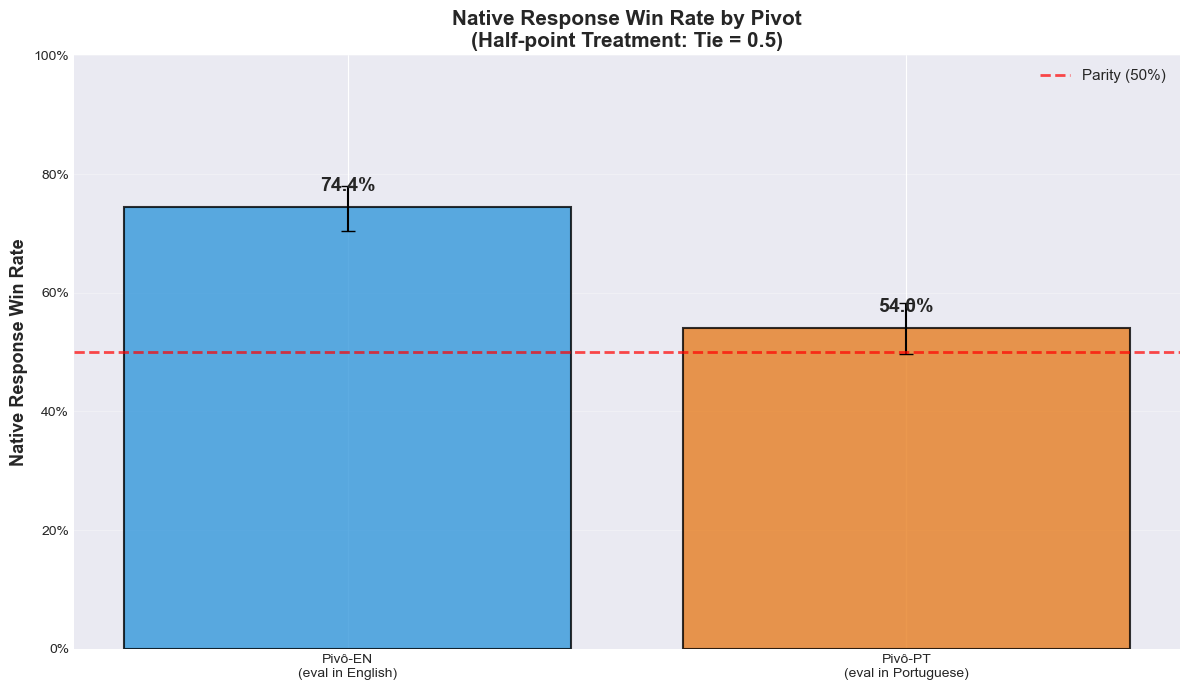

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

# Usar apenas half_point para simplicidade visual
df_plot = df_results[df_results['Treatment'] == 'half_point']

x = np.arange(len(df_plot))
colors = ['#3498db', '#e67e22']

bars = ax.bar(
    x,
    df_plot['Win_Rate'],
    yerr=[
        df_plot['Win_Rate'] - df_plot['IC_Inf'],
        df_plot['IC_Sup'] - df_plot['Win_Rate']
    ],
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

ax.set_ylabel('Native Response Win Rate', fontsize=13, weight='bold')
ax.set_title('Native Response Win Rate by Pivot\n(Half-point Treatment: Tie = 0.5)', 
             fontsize=15, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels([
    'Pivô-EN\n(eval in English)',
    'Pivô-PT\n(eval in Portuguese)'
])
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.axhline(0.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Parity (50%)')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, row in zip(bars, df_plot.itertuples()):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.02,
        f'{row.Win_Rate:.1%}',
        ha='center',
        va='bottom',
        fontsize=14,
        weight='bold'
    )

plt.tight_layout()
plt.show()

## TESTE DE HIPÓTESE: NATIVA vs TRADUZIDA

H₀: Taxa de vitória da nativa = 0.5 (sem vantagem)

In [12]:
# Teste para cada pivô (usando half_point)
test_results = []

for pivot_df, pivot_name, pivot_code in [
    (df_pivot_en, 'Pivô-EN', 'EN'),
    (df_pivot_pt, 'Pivô-PT', 'PT')
]:
    print(f"\n{pivot_name}:")
    print("-" * 50)
    
    # Calcular taxa de vitória (half_point)
    wr, ic_inf, ic_sup, n = calcular_win_rate_com_empates(pivot_df, 'half_point')
    
    print(f"Taxa de vitória (nativa): {formatar_ic(wr, ic_inf, ic_sup)}")
    print(f"N = {n}")
    
    # Teste Z para proporção
    p0 = 0.5
    se = np.sqrt(p0 * (1 - p0) / n)
    z_stat = (wr - p0) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    print(f"\nTeste Z:")
    print(f"  z = {z_stat:.3f}")
    print(f"  p-valor = {p_value:.4g}")
    
    # Interpretação
    if p_value < 0.001:
        sig = "***"
        conclusion = "Altamente significativo"
    elif p_value < 0.01:
        sig = "**"
        conclusion = "Muito significativo"
    elif p_value < 0.05:
        sig = "*"
        conclusion = "Significativo"
    else:
        sig = "ns"
        conclusion = "Não significativo"
    
    print(f"    Significância: {sig} ({conclusion})")
    
    if p_value < 0.05:
        direction = "vantagem" if wr > 0.5 else "desvantagem"
        effect_size = abs(wr - 0.5)
        print(f"    A resposta nativa apresenta {direction} (tamanho do efeito: {effect_size:.1%})")
        
        # Cohen's h
        cohens_h = 2 * np.arcsin(np.sqrt(wr)) - 2 * np.arcsin(np.sqrt(0.5))
        print(f"    Cohen's h = {cohens_h:.3f}", end="")
        if abs(cohens_h) < 0.2:
            print(" (efeito pequeno)")
        elif abs(cohens_h) < 0.5:
            print(" (efeito médio)")
        else:
            print(" (efeito grande)")
    else:
        print(f"    Nenhuma diferença significativa em relação à paridade")
    
    test_results.append({
        'Pivô': pivot_code,
        'Taxa_Vitória': wr,
        'Z': z_stat,
        'P_Valor': p_value,
        'Significativo': p_value < 0.05
    })



Pivô-EN:
--------------------------------------------------
Taxa de vitória (nativa): 74.4% (95% CI: [70.4%, 78.0%])
N = 500

Teste Z:
  z = 10.912
  p-valor = 0
    Significância: *** (Altamente significativo)
    A resposta nativa apresenta vantagem (tamanho do efeito: 24.4%)
    Cohen's h = 0.510 (efeito grande)

Pivô-PT:
--------------------------------------------------
Taxa de vitória (nativa): 54.0% (95% CI: [49.6%, 58.3%])
N = 500

Teste Z:
  z = 1.789
  p-valor = 0.07364
    Significância: ns (Não significativo)
    Nenhuma diferença significativa em relação à paridade


* EN: A vantagem de 74.4% do Inglês é altamente significativa.

* PT: A vantagem de 54.0% do Português não é estatisticamente significativa. Não podemos afirmar com 95% de confiança que a resposta nativa em PT é melhor; ela está estatisticamente empatada com a resposta traduzida.

## COMPARAÇÃO ENTRE PIVÔS

In [13]:
# Win rates dos dois pivôs
wr_en = df_results[(df_results['Pivot'] == 'EN') & 
                   (df_results['Treatment'] == 'half_point')]['Win_Rate'].values[0]
wr_pt = df_results[(df_results['Pivot'] == 'PT') & 
                   (df_results['Treatment'] == 'half_point')]['Win_Rate'].values[0]

In [14]:
asymmetry = abs(wr_en - wr_pt)

print(f"Taxa de vitória (nativa) no Pivô-EN: {wr_en:.1%}")
print(f"Taxa de vitória (nativa) no Pivô-PT: {wr_pt:.1%}")
print(f"\nAssimetria: {asymmetry:.1%}")
print()

# Interpretação da assimetria
if asymmetry > 0.15:
    print("ALTA ASSIMETRIA (>15pp)")
    print(" Resultados diferentes dependendo do idioma da avaliação")
    print(" Sugere viés de avaliação ou efeitos específicos do idioma")
elif asymmetry > 0.10:
    print("ASSIMETRIA MODERADA (>10pp)")
    print(" Alguma diferença entre os pivôs")
elif asymmetry > 0.05:
    print("BAIXA ASSIMETRIA (5–10pp)")
    print(" Diferenças pequenas, efeito relativamente robusto")
else:
    print("ASSIMETRIA MÍNIMA (<5pp)")
    print(" Efeito altamente robusto entre idiomas de avaliação")

Taxa de vitória (nativa) no Pivô-EN: 74.4%
Taxa de vitória (nativa) no Pivô-PT: 54.0%

Assimetria: 20.4%

ALTA ASSIMETRIA (>15pp)
 Resultados diferentes dependendo do idioma da avaliação
 Sugere viés de avaliação ou efeitos específicos do idioma


In [15]:
# Teste de diferença entre dois pivôs (teste Z para diferença de proporções)
n_en = len(df_pivot_en)
n_pt = len(df_pivot_pt)

# Proporção combinada (sob H₀)
n_native_en = (df_pivot_en['winner_type'] == 'Native').sum()
n_tie_en = (df_pivot_en['winner_type'] == 'Tie').sum()
n_native_pt = (df_pivot_pt['winner_type'] == 'Native').sum()
n_tie_pt = (df_pivot_pt['winner_type'] == 'Tie').sum()

# Ajuste para empates (half_point)
effective_native_en = n_native_en + 0.5 * n_tie_en
effective_native_pt = n_native_pt + 0.5 * n_tie_pt

p_pooled = (effective_native_en + effective_native_pt) / (n_en + n_pt)
se_diff = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_en + 1/n_pt))

z_diff = (wr_en - wr_pt) / se_diff
p_value_diff = 2 * (1 - stats.norm.cdf(abs(z_diff)))

print(f"Z = {z_diff:.3f}")
print(f"p-valor = {p_value_diff:.4g}")

if p_value_diff < 0.05:
    print("\nAs taxas de vitória diferem significativamente entre os pivôs")
    print("O idioma da avaliação influencia o resultado")
else:
    print("\nAs taxas de vitória são semelhantes entre os pivôs")
    print("O efeito é robusto ao idioma de avaliação")

Z = 6.728
p-valor = 1.719e-11

As taxas de vitória diferem significativamente entre os pivôs
O idioma da avaliação influencia o resultado


Não só as taxas de vitória são diferentes, como a diferença em si é significativa entre a comparação entre português e inglês. Isto prova que o idioma da avaliação influencia o resultado.

## MODELAGEM BRADLEY-TERRY

O modelo Bradley-Terry estima os parâmetros de "força":
- Maior força → maior probabilidade de vitória em comparações pareadas
- A razão logarítmica de chances quantifica a vantagem relativa

In [16]:
def estimate_bt_strength_with_ties(wins_native, wins_translated, ties):
    """
    Estimativa de força Bradley-Terry com empates
    Usa half-point: ties contam como 0.5 para cada lado
    """
    effective_native = wins_native + 0.5 * ties
    effective_translated = wins_translated + 0.5 * ties
    total = effective_native + effective_translated
    
    # Forças normalizadas
    strength_native = effective_native / total
    strength_translated = effective_translated / total
    
    # Log-odds ratio
    if strength_translated > 0:
        log_odds = np.log(strength_native / strength_translated)
    else:
        log_odds = np.inf
    
    return strength_native, strength_translated, log_odds

In [17]:
bt_results = []

for pivot_df, pivot_name, pivot_code in [
    (df_pivot_en, 'Pivô-EN (EN nativo vs PT traduzido)', 'EN'),
    (df_pivot_pt, 'Pivô-PT (PT nativo vs EN traduzido)', 'PT')
]:
    wins_native = (pivot_df['winner_type'] == 'Native').sum()
    wins_translated = (pivot_df['winner_type'] == 'Translated').sum()
    ties = (pivot_df['winner_type'] == 'Tie').sum()
    
    strength_native, strength_trans, log_odds = estimate_bt_strength_with_ties(
        wins_native, wins_translated, ties
    )
    
    print(f"{pivot_name}:")
    print(f"  Força (nativo): {strength_native:.3f}")
    print(f"  Força (traduzido): {strength_trans:.3f}")
    print(f"  Log-odds ratio: {log_odds:+.3f}")
    print(f"  → A resposta nativa é {np.exp(log_odds):.2f}× mais forte")
    print()
    
    bt_results.append({
        'Pivot': pivot_code,
        'Pivot_Name': pivot_name,
        'Native_Strength': strength_native,
        'Translated_Strength': strength_trans,
        'Log_Odds': log_odds,
        'Odds_Ratio': np.exp(log_odds)
    })

df_bt = pd.DataFrame(bt_results)

Pivô-EN (EN nativo vs PT traduzido):
  Força (nativo): 0.744
  Força (traduzido): 0.256
  Log-odds ratio: +1.067
  → A resposta nativa é 2.91× mais forte

Pivô-PT (PT nativo vs EN traduzido):
  Força (nativo): 0.540
  Força (traduzido): 0.460
  Log-odds ratio: +0.160
  → A resposta nativa é 1.17× mais forte



Este modelo confirma matematicamente tudo o que vimos antes. A vantagem do Inglês Nativo é enorme, enquanto a vantagem do Português Nativo é muito pequena (quase nula).

In [18]:
log_odds_en = df_bt[df_bt['Pivot'] == 'EN']['Log_Odds'].values[0]
log_odds_pt = df_bt[df_bt['Pivot'] == 'PT']['Log_Odds'].values[0]

print("--- Comparação entre Pivôs ---")
print(f"Log-odds no Pivô-EN: {log_odds_en:+.3f}")
print(f"Log-odds no Pivô-PT: {log_odds_pt:+.3f}")
print(f"Diferença: {abs(log_odds_en - log_odds_pt):.3f}")

--- Comparação entre Pivôs ---
Log-odds no Pivô-EN: +1.067
Log-odds no Pivô-PT: +0.160
Diferença: 0.907


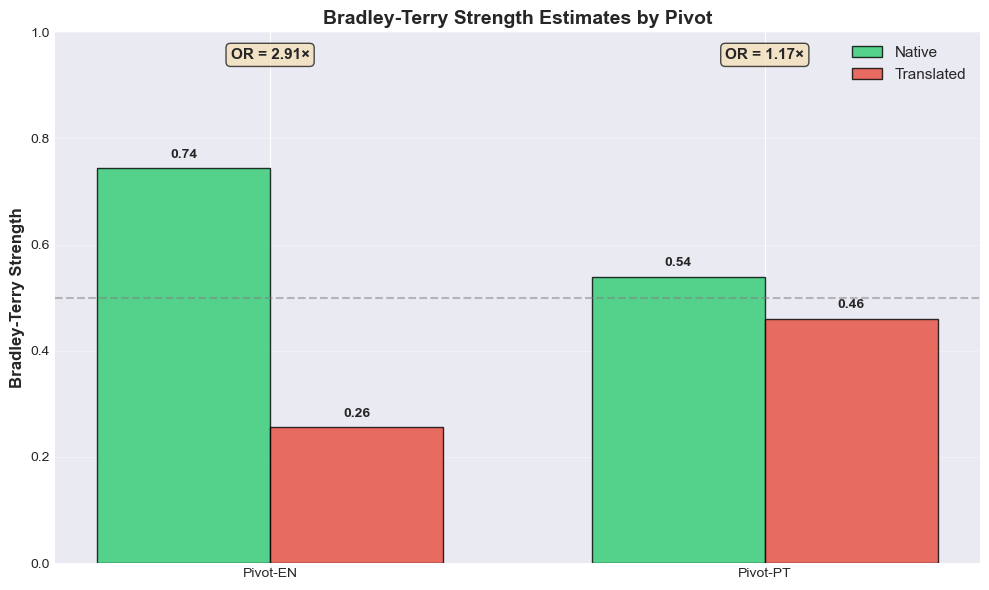

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

pivots = ['Pivot-EN', 'Pivot-PT']
native_strengths = df_bt['Native_Strength'].values
translated_strengths = df_bt['Translated_Strength'].values

x = np.arange(len(pivots))
width = 0.35

bars1 = ax.bar(x - width/2, native_strengths, width, 
               label='Native', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, translated_strengths, width, 
               label='Translated', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Bradley-Terry Strength', fontsize=12, weight='bold')
ax.set_title('Bradley-Terry Strength Estimates by Pivot', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivots)
ax.legend(fontsize=11)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Adicionar valores e odds ratios
for i, (bars_native, bars_trans, row) in enumerate(zip(bars1, bars2, df_bt.itertuples())):
    # Valores das barras
    ax.text(bars_native.get_x() + bars_native.get_width()/2, 
            bars_native.get_height() + 0.02,
            f'{row.Native_Strength:.2f}', 
            ha='center', fontsize=10, weight='bold')
    
    ax.text(bars_trans.get_x() + bars_trans.get_width()/2, 
            bars_trans.get_height() + 0.02,
            f'{row.Translated_Strength:.2f}', 
            ha='center', fontsize=10, weight='bold')
    
    # Odds ratio
    ax.text(i, 0.95, f'OR = {row.Odds_Ratio:.2f}×', 
            ha='center', fontsize=11, weight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

## ANÁLISE DE SENSIBILIDADE (TRATAMENTO DE EMPATES)

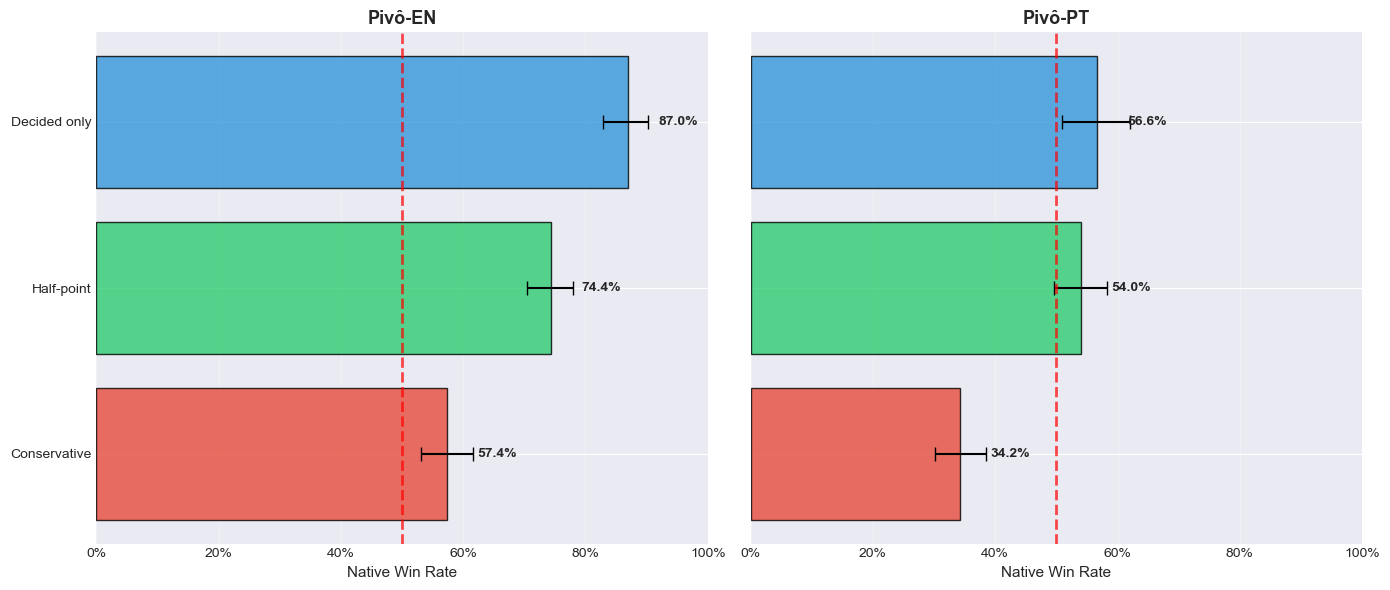

In [20]:
# Visualização: Sensibilidade
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, pivot in zip(axes, ['EN', 'PT']):
    subset = df_results[df_results['Pivot'] == pivot].copy()
    subset = subset.sort_values('Win_Rate', ascending=True)
    
    colors_map = {
        'conservative': '#e74c3c',
        'half_point': '#2ecc71',
        'decided_only': '#3498db'
    }
    
    colors = [colors_map[t] for t in subset['Treatment']]
    
    y_pos = np.arange(len(subset))
    
    bars = ax.barh(
        y_pos,
        subset['Win_Rate'],
        xerr=[
            subset['Win_Rate'] - subset['IC_Inf'],
            subset['IC_Sup'] - subset['Win_Rate']
        ],
        capsize=5,
        color=colors,
        alpha=0.8,
        edgecolor='black'
    )
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels([t.split('(')[0].strip() for t in subset['Treatment_Label']])
    ax.set_xlabel('Native Win Rate', fontsize=11)
    ax.set_title(f'Pivô-{pivot}', fontsize=13, weight='bold')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores
    for bar, row in zip(bars, subset.itertuples()):
        width = bar.get_width()
        ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
                f'{row.Win_Rate:.1%}',
                va='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

In [21]:
# Tabela resumo
print("--- Summary Table ---\n")
pivot_table = df_results.pivot(
    index='Treatment_Label', 
    columns='Pivot', 
    values='Win_Rate'
)
print(pivot_table.applymap(lambda x: f'{x:.1%}'))

--- Summary Table ---

Pivot                          EN     PT
Treatment_Label                         
Conservative (Tie=0)        57.4%  34.2%
Decided only (remove Ties)  87.0%  56.6%
Half-point (Tie=0.5)        74.4%  54.0%


/var/folders/lr/rv52d6g56jbdxpkrbhsvqjzr0000gn/T/ipykernel_23716/4206473684.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pivot_table.applymap(lambda x: f'{x:.1%}'))


In [22]:
# Robustez
print("--- Robustness Check ---\n")

for pivot in ['EN', 'PT']:
    subset = df_results[df_results['Pivot'] == pivot]
    min_wr = subset['Win_Rate'].min()
    max_wr = subset['Win_Rate'].max()
    range_wr = max_wr - min_wr
    
    print(f"Pivô-{pivot}:")
    print(f"    Range: {range_wr:.1%} (from {min_wr:.1%} to {max_wr:.1%})")
    
    # Verificar se todos os ICs excluem ou incluem 0.5
    all_above = all(subset['IC_Inf'] > 0.5)
    all_below = all(subset['IC_Sup'] < 0.5)
    
    if all_above:
        print(" ROBUSTO: Vantagem nativa em TODOS os tratamentos")
    elif all_below:
        print(" ROBUSTO: Desvantagem nativa em TODOS os tratamentos")
    else:
        print(" NÃO ROBUSTO: A conclusão depende do tratamento do empate")
    print()

--- Robustness Check ---

Pivô-EN:
    Range: 29.6% (from 57.4% to 87.0%)
 ROBUSTO: Vantagem nativa em TODOS os tratamentos

Pivô-PT:
    Range: 22.4% (from 34.2% to 56.6%)
 NÃO ROBUSTO: A conclusão depende do tratamento do empate



## ANÁLISE POR SUBGRUPOS

In [23]:
# Por domínio
domain_data = []

for pivot_df, pivot_name, pivot_code in [
    (df_pivot_en, 'Pivô-EN', 'EN'),
    (df_pivot_pt, 'Pivô-PT', 'PT')
]:
    print(f"{pivot_name}:")
    
    for domain in sorted(pivot_df['domain'].unique()):
        subset = pivot_df[pivot_df['domain'] == domain]
        wr, ic_inf, ic_sup, n = calcular_win_rate_com_empates(subset, 'half_point')
        
        print(f"  {domain:20s}: {formatar_ic(wr, ic_inf, ic_sup)} (N={n})")
        
        domain_data.append({
            'Pivot': pivot_code,
            'Domain': domain,
            'Win_Rate': wr,
            'IC_Inf': ic_inf,
            'IC_Sup': ic_sup,
            'N': n
        })
    print()

df_domain = pd.DataFrame(domain_data)

Pivô-EN:
  Creative            : 72.0% (95% CI: [63.6%, 79.1%]) (N=125)
  General Knowledge   : 77.8% (95% CI: [71.5%, 83.0%]) (N=198)
  Technical           : 72.3% (95% CI: [65.3%, 78.4%]) (N=177)

Pivô-PT:
  Creative            : 46.4% (95% CI: [37.9%, 55.1%]) (N=125)
  General Knowledge   : 50.8% (95% CI: [43.6%, 57.4%]) (N=198)
  Technical           : 63.0% (95% CI: [55.4%, 69.5%]) (N=177)



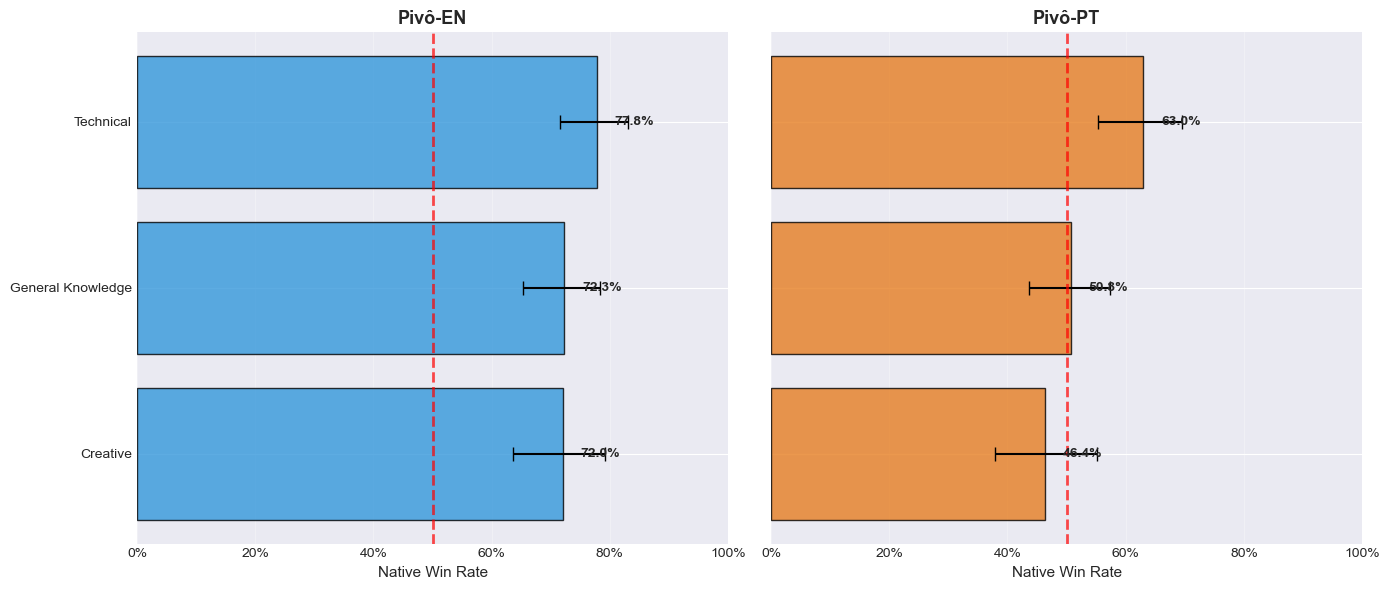

In [24]:
# Visualização: Por domínio
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, pivot in zip(axes, ['EN', 'PT']):
    subset = df_domain[df_domain['Pivot'] == pivot].sort_values('Win_Rate', ascending=True)
    
    y_pos = np.arange(len(subset))
    colors = ['#3498db' if pivot == 'EN' else '#e67e22'] * len(subset)
    
    bars = ax.barh(
        y_pos,
        subset['Win_Rate'],
        xerr=[
            subset['Win_Rate'] - subset['IC_Inf'],
            subset['IC_Sup'] - subset['Win_Rate']
        ],
        capsize=5,
        color=colors,
        alpha=0.8,
        edgecolor='black'
    )
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(subset['Domain'])
    ax.set_xlabel('Native Win Rate', fontsize=11)
    ax.set_title(f'Pivô-{pivot}', fontsize=13, weight='bold')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores
    for bar, row in zip(bars, subset.itertuples()):
        width = bar.get_width()
        ax.text(width + 0.03, bar.get_y() + bar.get_height()/2,
                f'{row.Win_Rate:.1%}',
                va='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()